## Vessels passing a lock
In this example we will discuss how to implement a lock in OpenTNSim and how to analyse specific locking output.

We take the following steps:

1. [Imports](#1.-Imports)
2. [Create vessel](#2.-Create-vessel)
3. [Create graph](#3.-Create-graph)
4. [Run simulation](#4.-Run-simulation)
5. [Inspect output](#5.-Inspect-output)

### 1. Imports
We start with importing required libraries

In [1]:
# package(s) used for creating and geo-locating the graph
import networkx as nx  
import shapely.geometry
import pyproj

# package(s) related to the simulation (creating the vessel, running the simulation)
import datetime, time
import simpy
import opentnsim
import opentnsim.lock
from opentnsim import core



# package(s) needed for data handling and inspecting output
import numpy as np
import pandas as pd

# package(s) needed for plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

print('This notebook is executed with OpenTNSim version {}'.format(opentnsim.__version__))

This notebook is executed with OpenTNSim version 1.1.2


### 2. Create vessel
We start with creating a vessel class. We call this class a *Vessel*, and add a number of OpenTNSim mix-ins to this class. Each mix-in requires certain input parameters. 

The following mix-ins are sufficient to create a vessel for our problem: 
* _Identifiable_ - allows to give the vessel a name and a random ID, 
* _Movable_ - allows the vessel to move, with a fixed speed, while logging this activity,
   * Movable in turn relies on the mix-ins: _Locatable_, _Routeable_, and _Log_
* _VesselProperties_ - allows to give the vessel specific properties, 
* _HasContainer_ - allows vessel to have cargo on board, 
* _HasResource_ - allows vessel to be requested   

In [2]:
TransportResource = type(
    "Vessel",
    (
        core.Identifiable,
        core.Movable,
        core.VesselProperties,
        core.HasContainer,
        core.HasResource,
        core.ExtraMetadata,
    ),
    {},
)

In [3]:
data_vessel = {
    "env": None,
    "name": "Vessel",
    "route": None, 
    "geometry": None, 
    "capacity": 1_000,
    "vessel_type": "CEMT - Va",
    "width": 11.40,
    "height_empty": 7.10,
    "height_full": 5.40,
    "draught_empty": 1.8,
    "draught_full": 3.5,
    "v": 3,
    "B": 11.4,
    "L": 135,
    "length": 135.0,
    "type": "CEMT - Va",
}

vessel = TransportResource(**data_vessel)

### 2. Create graph
Next we create a 1D network (a graph) along which the vessel can move. Basics are the same. However, instead here it is chosen to build a graph with distances, as it is more convenient to impose a lock with certain dimensions on such a graph.

In [4]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = []
coords.append([0, 0])

# for each edge specify the distance (m)
distances = [550, 500, 300, 500, 150, 150, 500, 300, 500, 550]

# create world coordinates based on the indicated distances
for d in range(len(distances)):
    coords.append(
        [
            pyproj.Geod(ellps="WGS84").fwd(
                coords[d][0], coords[d][1], 90, distances[d]
            )[0],
            0,
        ]
    )

In [5]:
# create a graph 
FG = nx.DiGraph()
nodes = []
path = []

# make your preferred Site class out of available mix-ins.
Node = type("Site", (core.Identifiable, core.Log, core.Locatable, core.HasResource), {})

# add nodes
for d in range(len(coords)):
    data_node = {
        "env": [],
        "name": str(d + 1),
        "geometry": shapely.geometry.Point(coords[d][0], coords[d][1]),
    }
    node = Node(**data_node)
    nodes.append(node)

for i in range(2):
    if i == 0:
        for j in range(len(nodes) - 1):
            path.append([nodes[j], nodes[j + 1]])
    if i == 1:
        for j in range(len(nodes) - 1):
            path.append([nodes[j + 1], nodes[j]])

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry=node.geometry)

# add edges
for edge in path:
    FG.add_edge(edge[0].name, edge[1].name, weight=1)

# fig, ax = plt.subplots(figsize=(10, 10))
# nx.draw(FG, positions, ax=ax)
# plt.show()

In [6]:
# create a positions dict for the purpose of plotting
positions = {}
for node in FG.nodes:
    positions[node] = (FG.nodes[node]['geometry'].x, FG.nodes[node]['geometry'].y)

In [7]:
# collect node labels.
labels = {}
for node in FG.nodes:
    labels[node] = node

Number of nodes is 11:
Number of edges is 20:


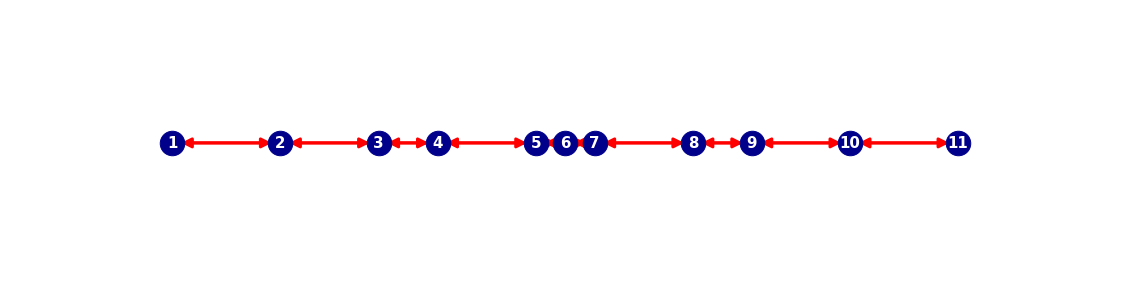

In [8]:
print('Number of nodes is {}:'.format(len(FG.nodes)))
print('Number of edges is {}:'.format(len(FG.edges)))

fig, ax = plt.subplots(figsize=(20, 5))

# draw edges, nodes and labels.
nx.draw_networkx_edges(FG,  pos=positions, width=3, edge_color="red", alpha=1, arrowsize=20)
nx.draw_networkx_nodes(FG,  pos=positions, node_color="darkblue", node_size=600)
nx.draw_networkx_labels(FG, pos=positions, labels=labels, font_size=15, font_weight='bold', font_color="white")

plt.axis("off")
plt.show()

### 4. Run simulation
Now we can define the run. After we define the path that the vessel will sail, we make an environment and add the graph to the environment. Then we add one vessel, to which we will append the environment and the route. Lastly, we give the vessel the process of moving from the origin to the destination of the defined path and subsequently run the model.

In [9]:
start_point = "1"
end_point = "11"

path = nx.dijkstra_path(FG, start_point, end_point, weight="length")
origin = FG.nodes[start_point]["geometry"]

In [10]:
simulation_start = datetime.datetime.now()
env = simpy.Environment(initial_time=time.mktime(simulation_start.timetuple()))
env.epoch = time.mktime(simulation_start.timetuple())

A lock complex consists of a lock chamber, and a waiting area and line-up area on both sides of the chamber. You need to impose certain parameters.

In [11]:
# define the lock
waiting_area_1 = opentnsim.lock.IsLockWaitingArea(
    env=env, nr_resources=1, priority=True, name="Volkeraksluizen_1", node="2"
)

lineup_area_1 = opentnsim.lock.IsLockLineUpArea(
    env=env,
    nr_resources=1,
    priority=True,
    name="Volkeraksluizen_1",
    node="3",
    lineup_length=300,
)

lock_1 = opentnsim.lock.IsLock(
    env=env,
    nr_resources=100,
    priority=True,
    name="Volkeraksluizen_1",
    node_1="5",
    node_2="6",
    node_3="7",
    lock_length=300,
    lock_width=24,
    lock_depth=4.5,
    doors_open=10 * 60,
    doors_close=10 * 60,
    wlev_dif=2.0,
    disch_coeff=0.8,
    grav_acc=9.81,
    opening_area=4.0,
    opening_depth=5.0,
    simulation_start=simulation_start,
    operating_time=25 * 60,
)

waiting_area_2 = opentnsim.lock.IsLockWaitingArea(
    env=env, nr_resources=1, priority=True, name="Volkeraksluizen_1", node="10"
)

lineup_area_2 = opentnsim.lock.IsLockLineUpArea(
    env=env,
    nr_resources=1,
    priority=True,
    name="Volkeraksluizen_1",
    node="9",
    lineup_length=300,
)

Now, we need to impose the areas on the graph.

In [12]:
lock_1.water_level = "5"
FG.nodes["6"]["Lock"] = [lock_1]

FG.nodes["2"]["Waiting area"] = [waiting_area_1]
FG.nodes["3"]["Line-up area"] = [lineup_area_1]

FG.nodes["10"]["Waiting area"] = [waiting_area_2]
FG.nodes["9"]["Line-up area"] = [lineup_area_2]

In [13]:
# Add graph to environment
env.FG = FG

# Add environment and path to the vessel
vessels = []

vessel.env = env  # the created environment
vessel.name = "Vessel No.1"
vessel.route = path  # the route (the sequence of nodes, as stored as the second column in the path)
vessel.geometry = env.FG.nodes[path[0]][
    "geometry"
]  # a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)

vessels.append(vessel)

# Start the simulation
for vessel in vessels:
    vessel.env = env
    env.process(vessel.move())
    
env.run()

### Output

In [14]:
df = pd.DataFrame.from_dict(vessels[0].logbook)
df

,Message,Timestamp,Value,Geometry
0,Sailing from node 1 to node 2 start,2023-05-23 23:59:56.000000,0,POINT (0 0)
1,Sailing from node 1 to node 2 stop,2023-05-24 00:02:59.333333,0,POINT (0.0049407340626574 0)
2,Sailing from node 2 to node 3 start,2023-05-24 00:02:59.333333,0,POINT (0.0049407340626574 0)
3,Sailing from node 2 to node 3 stop,2023-05-24 00:05:46.000000,0,POINT (0.009432310483255 0)
4,Sailing from node 3 to node 4 start,2023-05-24 00:05:46.000000,0,POINT (0.009432310483255 0)
5,Sailing from node 3 to node 4 stop,2023-05-24 00:07:26.000000,0,POINT (0.0121272563356135 0)
6,Sailing from node 4 to node 5 start,2023-05-24 00:07:26.000000,0,POINT (0.0121272563356135 0)
7,Sailing from node 4 to node 5 stop,2023-05-24 00:10:12.666667,0,POINT (0.0166188327562111 0)
8,Sailing from node 5 to node 6 start,2023-05-24 00:10:12.666667,0,POINT (0.0166188327562111 0)
9,Sailing from node 5 to node 6 stop,2023-05-24 00:11:02.666667,0,POINT (0.0179663056823904 0)


In [15]:
locking_cycle_start_dir1 = simulation_start.timestamp()
locking_cycle_starts_dir1 = []
locking_cycle_stop_dir1 = simulation_start.timestamp()
locking_cycle_stops_dir1 = []
locking_cycle_start_dir2 = simulation_start.timestamp()
locking_cycle_starts_dir2 = []
locking_cycle_stop_dir2 = simulation_start.timestamp()
locking_cycle_stops_dir2 = []

for v in range(0, len(vessels)):
    for t in range(0, len(vessels[v].logbook) - 1):
        row = vessels[v].logbook[t]
        if vessels[v].route[0] == "Node 1":
            if row["Message"] == "Passing lock start":
                if (
                    locking_cycle_start_dir1
                    <= row["Timestamp"].timestamp()
                    <= locking_cycle_stop_dir1
                ):
                    pass
                else:
                    locking_cycle_start_dir1 = (
                        vessels[v].logbook[t-2]["Timestamp"].timestamp()
                    )
                    locking_cycle_starts_dir1.append(
                        [vessels[v].logbook[t-2]["Timestamp"].timestamp(), "Start"]
                    )
                    locking_cycle_stop_dir1 = (
                        vessels[v].logbook[t + 1]["Timestamp"].timestamp()
                    )
                    for v2 in range(v, len(vessels)):
                        for t2 in range(0, len(vessels[v2].logbook) - 1):
                            if vessels[v2].logbook[t2]["Message"] == "Passing lock stop":
                                if (
                                    locking_cycle_start_dir1
                                    <= vessels[v2].logbook[t2 - 1]["Timestamp"].timestamp()
                                    <= locking_cycle_stop_dir1
                                    and vessels[v2].route[0] == "Node 1"
                                ):
                                    if len(locking_cycle_starts_dir1) != len(
                                        locking_cycle_stops_dir1
                                    ):
                                        locking_cycle_stops_dir1.append(
                                            [
                                                vessels[v2]
                                                .logbook[t2 + 2]["Timestamp"]
                                                .timestamp(),
                                                "Stop",
                                            ]
                                        )
                                    elif (
                                        vessels[v2].logbook[t2 + 2]["Timestamp"].timestamp()
                                        > locking_cycle_stops_dir1[-1][0]
                                    ):
                                        locking_cycle_stops_dir1[-1][0] = (
                                            vessels[v2]
                                            .logbook[t2 + 2]["Timestamp"]
                                            .timestamp()
                                        )

        elif vessels[v].route[0] == "Node 21":
            if vessels[v].logbook[t]["Message"] == "Passing lock start":
                if (
                    locking_cycle_start_dir2
                    <= vessels[v].logbook[t]["Timestamp"].timestamp()
                    <= locking_cycle_stop_dir2
                ):
                    pass
                else:
                    locking_cycle_start_dir2 = (
                        vessels[v].logbook[t - 2]["Timestamp"].timestamp()
                    )
                    locking_cycle_starts_dir2.append(
                        [vessels[v].logbook[t - 2]["Timestamp"].timestamp(), "Start"]
                    )
                    locking_cycle_stop_dir2 = (
                        vessels[v].logbook[t + 1]["Timestamp"].timestamp()
                    )
                    for v2 in range(v, len(vessels)):
                        for t2 in range(0, len(vessels[v2].logbook) - 1):
                            if vessels[v2].logbook[t2]["Message"] == "Passing lock stop":
                                if (
                                    locking_cycle_start_dir2
                                    <= vessels[v2].logbook[t2 - 1]["Timestamp"].timestamp()
                                    <= locking_cycle_stop_dir2
                                    and vessels[v2].route[0] == "Node 21"
                                ):
                                    if len(locking_cycle_starts_dir2) != len(
                                        locking_cycle_stops_dir2
                                    ):
                                        locking_cycle_stops_dir2.append(
                                            [
                                                vessels[v2]
                                                .logbook[t2 + 2]["Timestamp"]
                                                .timestamp(),
                                                "Stop",
                                            ]
                                        )
                                    elif (
                                        vessels[v2].logbook[t2 + 2]["Timestamp"].timestamp()
                                        > locking_cycle_stops_dir2[-1][0]
                                    ):
                                        locking_cycle_stops_dir2[-1][0] = (
                                            vessels[v2]
                                            .logbook[t2 + 2]["Timestamp"]
                                            .timestamp()
                                        )

inoperation_time_doors1 = locking_cycle_starts_dir2 + locking_cycle_stops_dir1
inoperation_time_doors1.sort()
inoperation_time_doors2 = locking_cycle_starts_dir1 + locking_cycle_stops_dir2
inoperation_time_doors2.sort()
loop_time_doors1 = []
loop_time_doors2 = []

for i in range(len(inoperation_time_doors1)):
    if (
        i != 0
        and inoperation_time_doors1[i][1] == "Start"
        and inoperation_time_doors1[i - 1][1] != "Start"
    ):
        loop_time_doors1.append(
            (inoperation_time_doors1[i][0] - inoperation_time_doors1[i - 1][0]) / 60
        )

for i in range(len(inoperation_time_doors2)):
    if (
        i != 0
        and inoperation_time_doors2[i][1] == "Start"
        and inoperation_time_doors2[i - 1][1] != "Start"
    ):
        loop_time_doors2.append(
            (inoperation_time_doors2[i][0] - inoperation_time_doors2[i - 1][0]) / 60
        )

In [16]:
waiting_to_waiting_area = []
waiting_in_waiting_area = []
waiting_in_lineup_area = []
waiting_in_lock = []
total_waiting_time = np.zeros(len(vessels))

for v in range(0, len(vessels)):
    for t in range(0, len(vessels[v].logbook) - 1):
        if vessels[v].logbook[t]["Message"] == "Waiting to enter waiting area stop":
            waiting_to_waiting_area.append(vessels[v].logbook[t]["Value"] / 60)
        if vessels[v].logbook[t]["Message"] == "Waiting in waiting area stop":
            waiting_in_waiting_area.append(vessels[v].logbook[t]["Value"] / 60)
        if vessels[v].logbook[t]["Message"] == "Waiting in line-up area stop":
            waiting_in_lineup_area.append(vessels[v].logbook[t]["Value"] / 60)
        if vessels[v].logbook[t]["Message"] == "Passing lock stop":
            waiting_in_lock.append(vessels[v].logbook[t]["Value"] / 60)

for v in range(len(vessels)):
    for t in range(0, len(vessels[v].logbook) - 1):
        if (
            vessels[v].logbook[t]["Message"] == "Waiting to enter waiting area stop"
            or vessels[v].logbook[t]["Message"] == "Waiting in waiting area stop"
            or vessels[v].logbook[t]["Message"] == "Waiting in line-up area stop"
            or vessels[v].logbook[t]["Message"] == "Passing lock stop"
        ):
            total_waiting_time[v] += vessels[v].logbook[t]["Value"] / 60

In [17]:
def calculate_distance(orig, dest):
    wgs84 = pyproj.Geod(ellps="WGS84")

    distance = wgs84.inv(orig[0], orig[1], dest[0], dest[1])[2]

    return distance


vessel_path_x = []
vessel_path_t = []
origin = "1"
destination = "11"

for v in range(0, len(vessels)):
    vessel_path_xt = []
    vessel_path_tt = []
    for t in range(0, len(vessels[v].logbook)):
        if vessels[v].route[0] == "1":
            vessel_path_x0 = (
                vessels[v].logbook[0]["Geometry"].x,
                vessels[v].logbook[0]["Geometry"].y,
            )
            vessel_path_t0 = simulation_start.timestamp()
            vessel_path_xt.append(
                calculate_distance(
                    vessel_path_x0,
                    (vessels[v].logbook[t]["Geometry"].x, vessels[v].logbook[t]["Geometry"].y),
                )
            )
            vessel_path_tt.append(
                vessels[v].logbook[t]["Timestamp"].timestamp() - vessel_path_t0
            )
        if vessels[v].route[0] == "11":
            vessel_path_x0 = (
                vessels[v].logbook[0]["Geometry"].x,
                vessels[v].logbook[0]["Geometry"].y,
            )
            vessel_path_t0 = simulation_start.timestamp()
            vessel_path_xt.append(
                calculate_distance(
                    (
                        env.FG.nodes[destination]["geometry"].x,
                        env.FG.nodes[destination]["geometry"].y,
                    ),
                    (
                        env.FG.nodes[origin]["geometry"].x,
                        env.FG.nodes[origin]["geometry"].y,
                    ),
                )
                - calculate_distance(
                    vessel_path_x0,
                    (vessels[v].logbook[t]["Geometry"].x, vessels[v].logbook[t]["Geometry"].y),
                )
            )
            vessel_path_tt.append(
                vessels[v].logbook[t]["Timestamp"].timestamp() - vessel_path_t0
            )
    vessel_path_x.append(vessel_path_xt)
    vessel_path_t.append(vessel_path_tt)

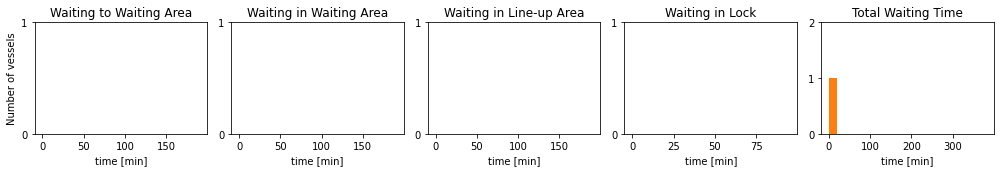

In [18]:
data = [
    waiting_to_waiting_area,
    waiting_in_waiting_area,
    waiting_in_lineup_area,
    waiting_in_lock,
    total_waiting_time,
]
xaxes = "time [min]"
titles = [
    "Waiting to Waiting Area",
    "Waiting in Waiting Area",
    "Waiting in Line-up Area",
    "Waiting in Lock",
    "Total Waiting Time",
]
bins = [
    range(0, 200, 10),
    range(0, 200, 10),
    range(0, 200, 10),
    range(0, 100, 5),
    range(0, 400, 20),
]

f, a = plt.subplots(1, 5, figsize=(14, 2.5))
a = a.ravel()
for idx, ax in enumerate(a):
    if idx == 0:
        ax.set_ylabel("Number of vessels")
    ax.hist(data[idx], bins=bins[idx])
    ax.set_title(titles[idx])
    ax.set_xlabel(xaxes)
    ax.set_ylim(0, max(ax.hist(data[idx], bins=bins[idx])[0]) + 1)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()

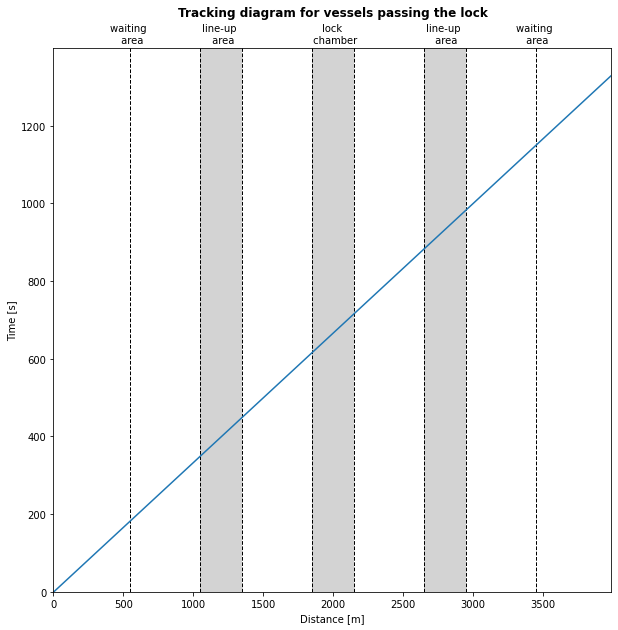

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.axvline(
    x=calculate_distance(
        vessel_path_x0,
        (FG.nodes["2"]["geometry"].x, FG.nodes["2"]["geometry"].y),
    ),
    color="k",
    linestyle="--",
    linewidth=1.0,
)
plt.axvline(
    x=calculate_distance(
        vessel_path_x0,
        (FG.nodes["3"]["geometry"].x, FG.nodes["3"]["geometry"].y),
    ),
    color="k",
    linestyle="--",
    linewidth=1.0,
)
plt.axvline(
    x=calculate_distance(
        vessel_path_x0,
        (FG.nodes["4"]["geometry"].x, FG.nodes["4"]["geometry"].y),
    ),
    color="k",
    linestyle="--",
    linewidth=1.0,
)
plt.axvline(
    x=calculate_distance(
        vessel_path_x0,
        (FG.nodes["5"]["geometry"].x, FG.nodes["5"]["geometry"].y),
    ),
    color="k",
    linestyle="--",
    linewidth=1.0,
)
plt.axvline(
    x=calculate_distance(
        vessel_path_x0,
        (FG.nodes["7"]["geometry"].x, FG.nodes["7"]["geometry"].y),
    ),
    color="k",
    linestyle="--",
    linewidth=1.0,
)
plt.axvline(
    x=calculate_distance(
        vessel_path_x0,
        (FG.nodes["8"]["geometry"].x, FG.nodes["8"]["geometry"].y),
    ),
    color="k",
    linestyle="--",
    linewidth=1.0,
)
plt.axvline(
    x=calculate_distance(
        vessel_path_x0,
        (FG.nodes["9"]["geometry"].x, FG.nodes["9"]["geometry"].y),
    ),
    color="k",
    linestyle="--",
    linewidth=1.0,
)
plt.axvline(
    x=calculate_distance(
        vessel_path_x0,
        (FG.nodes["10"]["geometry"].x, FG.nodes["10"]["geometry"].y),
    ),
    color="k",
    linestyle="--",
    linewidth=1.0,
)
for v in reversed(range(0, len(vessels))):
    plt.plot(vessel_path_x[v], vessel_path_t[v])

plt.text(
    calculate_distance(
        vessel_path_x0,
        (FG.nodes["6"]["geometry"].x, FG.nodes["6"]["geometry"].y),
    ),
    ax.get_ylim()[1] + 0.01 * ax.get_ylim()[1],
    "lock \n chamber",
    horizontalalignment="center",
)
plt.text(
    calculate_distance(
        vessel_path_x0,
        (FG.nodes["9"]["geometry"].x, FG.nodes["9"]["geometry"].y),
    )
    - 0.5
    * calculate_distance(
        (FG.nodes["8"]["geometry"].x, FG.nodes["8"]["geometry"].y),
        (FG.nodes["9"]["geometry"].x, FG.nodes["9"]["geometry"].y),
    ),
    ax.get_ylim()[1] + 0.01 * ax.get_ylim()[1],
    "line-up \n area",
    horizontalalignment="center",
)
plt.text(
    calculate_distance(
        vessel_path_x0,
        (FG.nodes["3"]["geometry"].x, FG.nodes["3"]["geometry"].y),
    )
    + 0.5
    * calculate_distance(
        (FG.nodes["4"]["geometry"].x, FG.nodes["4"]["geometry"].y),
        (FG.nodes["3"]["geometry"].x, FG.nodes["3"]["geometry"].y),
    ),
    ax.get_ylim()[1] + 0.01 * ax.get_ylim()[1],
    "line-up \n area",
    horizontalalignment="center",
)
plt.text(
    calculate_distance(
        vessel_path_x0,
        (FG.nodes["10"]["geometry"].x, FG.nodes["10"]["geometry"].y),
    ),
    ax.get_ylim()[1] + 0.01 * ax.get_ylim()[1],
    "waiting \n area",
    horizontalalignment="center",
)
plt.text(
    calculate_distance(
        vessel_path_x0,
        (FG.nodes["2"]["geometry"].x, FG.nodes["2"]["geometry"].y),
    ),
    ax.get_ylim()[1] + 0.01 * ax.get_ylim()[1],
    "waiting \n area",
    horizontalalignment="center",
)

plt.title("Tracking diagram for vessels passing the lock", fontweight="bold", pad=32)
plt.xlabel("Distance [m]")
plt.xlim([0, 0.95 * ax.get_xlim()[1]])
plt.ylim([0, ax.get_ylim()[1]])
plt.ylabel("Time [s]")

plt.fill(
    [
        calculate_distance(
            vessel_path_x0,
            (FG.nodes["3"]["geometry"].x, FG.nodes["3"]["geometry"].y),
        ),
        calculate_distance(
            vessel_path_x0,
            (FG.nodes["3"]["geometry"].x, FG.nodes["3"]["geometry"].y),
        ),
        calculate_distance(
            vessel_path_x0,
            (FG.nodes["4"]["geometry"].x, FG.nodes["4"]["geometry"].y),
        ),
        calculate_distance(
            vessel_path_x0,
            (FG.nodes["4"]["geometry"].x, FG.nodes["4"]["geometry"].y),
        ),
    ],
    [0, ax.get_ylim()[1], ax.get_ylim()[1], 0],
    "lightgrey",
)

plt.fill(
    [
        calculate_distance(
            vessel_path_x0,
            (FG.nodes["5"]["geometry"].x, FG.nodes["5"]["geometry"].y),
        ),
        calculate_distance(
            vessel_path_x0,
            (FG.nodes["5"]["geometry"].x, FG.nodes["5"]["geometry"].y),
        ),
        calculate_distance(
            vessel_path_x0,
            (FG.nodes["7"]["geometry"].x, FG.nodes["7"]["geometry"].y),
        ),
        calculate_distance(
            vessel_path_x0,
            (FG.nodes["7"]["geometry"].x, FG.nodes["7"]["geometry"].y),
        ),
    ],
    [0, ax.get_ylim()[1], ax.get_ylim()[1], 0],
    "lightgrey",
)

plt.fill(
    [
        calculate_distance(
            vessel_path_x0,
            (FG.nodes["8"]["geometry"].x, FG.nodes["8"]["geometry"].y),
        ),
        calculate_distance(
            vessel_path_x0,
            (FG.nodes["8"]["geometry"].x, FG.nodes["8"]["geometry"].y),
        ),
        calculate_distance(
            vessel_path_x0,
            (FG.nodes["9"]["geometry"].x, FG.nodes["9"]["geometry"].y),
        ),
        calculate_distance(
            vessel_path_x0,
            (FG.nodes["9"]["geometry"].x, FG.nodes["9"]["geometry"].y),
        ),
    ],
    [0, ax.get_ylim()[1], ax.get_ylim()[1], 0],
    "lightgrey",
)

plt.show()

In [20]:
df = pd.DataFrame.from_dict(lock_1.log)
df

,Timestamp,ActivityID,ActivityState,ObjectState,ActivityLabel


In [21]:
door_open_time_doors_1 = []
door_open_time_doors_2 = []
end_time = []
for v in range(0, len(vessels)):
    end_time.append(vessels[v].log["Timestamp"][-1].timestamp())
end_of_simulation = max(end_time)

for l in range(0, len(env.FG.nodes["6"]["Lock"])):
    for t in range(0, len(env.FG.nodes["6"]["Lock"][l].logbook) - 1):
        if (
            env.FG.nodes["6"]["Lock"][l].logbook[t]["Message"]
            == "Lock doors closing stop"
            and env.FG.nodes["6"]["Lock"][l].logbook[t]["Geometry"] == "5"
        ):
            for t2 in reversed(range(0, t)):
                if (
                    env.FG.nodes["6"]["Lock"][l].logbook[t2]["Message"]
                    == "Lock doors opening start"
                ):
                    door_open_time_doors_1.append(
                        env.FG.nodes["6"]["Lock"][l]
                        .logbook[t]["Timestamp"]
                        .timestamp()
                        / 60
                        - env.FG.nodes["6"]["Lock"][l]
                        .logbook[t2]["Timestamp"]
                        .timestamp()
                        / 60
                    )
                    break
            else:
                door_open_time_doors_1.append(
                    env.FG.nodes["6"]["Lock"][l].logbook[t]["Timestamp"].timestamp()
                    / 60
                    - simulation_start.timestamp() / 60
                )
        elif (
            env.FG.nodes["6"]["Lock"][l].logbook[t]["Message"]
            == "Lock doors closing stop"
            and env.FG.nodes["6"]["Lock"][l].logbook[t]["Geometry"] == "7"
        ):
            for t2 in reversed(range(0, t)):
                if (
                    env.FG.nodes["6"]["Lock"][l].logbook[t2]["Message"]
                    == "Lock doors opening start"
                ):
                    door_open_time_doors_2.append(
                        env.FG.nodes["6"]["Lock"][l]
                        .logbook[t]["Timestamp"]
                        .timestamp()
                        / 60
                        - env.FG.nodes["6"]["Lock"][l]
                        .logbook[t2]["Timestamp"]
                        .timestamp()
                        / 60
                    )
                    break
            else:
                door_open_time_doors_2.append(
                    env.FG.nodes["6"]["Lock"][l].logbook[t]["Timestamp"].timestamp()
                    / 60
                    - simulation_start.timestamp() / 60
                )

for l in range(0, len(env.FG.nodes["6"]["Lock"])):
    for t in reversed(range(0, len(env.FG.nodes["6"]["Lock"][l].logbook))):
        if (
            env.FG.nodes["6"]["Lock"][l].logbook[t]["Message"]
            == "Lock doors opening stop"
            and env.FG.nodes["6"]["Lock"][l].logbook[t]["Geometry"] == "5"
        ):
            for t2 in range(t, len(env.FG.nodes["6"]["Lock"][l].logbook)):
                if (
                    env.FG.nodes["6"]["Lock"][l].logbook[t2]["Message"]
                    == "Lock doors closing stop"
                ):
                    pass
            else:
                door_open_time_doors_1.append(
                    end_of_simulation / 60
                    - env.FG.nodes["6"]["Lock"][l].logbook[t]["Timestamp"].timestamp()
                    / 60
                )
                break
        elif (
            env.FG.nodes["6"]["Lock"][l].logbook[t]["Message"]
            == "Lock doors opening stop"
            and env.FG.nodes["6"]["Lock"][l].logbook[t]["Geometry"] == "7"
        ):
            for t2 in range(t, len(env.FG.nodes["6"]["Lock"][l].logbook)):
                if (
                    env.FG.nodes["6"]["Lock"][l].logbook[t2]["Message"]
                    == "Lock doors closing stop"
                ):
                    pass
            else:
                door_open_time_doors_2.append(
                    end_of_simulation / 60
                    - env.FG.nodes["6"]["Lock"][l].logbook[t]["Timestamp"].timestamp()
                    / 60
                )
                break

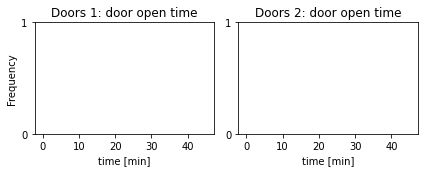

In [22]:
data = [door_open_time_doors_1, door_open_time_doors_2]
xaxes = "time [min]"
titles = ["Doors 1: door open time", "Doors 2: door open time"]
bins = [range(0, 50, 5), range(0, 50, 5)]

f, a = plt.subplots(1, 2, figsize=(6, 2.5))
a = a.ravel()
for idx, ax in enumerate(a):
    if idx == 0:
        ax.set_ylabel("Frequency")
    ax.hist(data[idx], bins=bins[idx])
    ax.set_title(titles[idx])
    ax.set_xlabel(xaxes)
    ax.set_ylim(0, max(ax.hist(data[idx], bins=bins[idx])[0]) + 1)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()

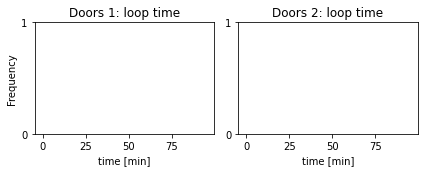

In [23]:
data = [loop_time_doors1, loop_time_doors2]
xaxes = "time [min]"
titles = ["Doors 1: loop time", "Doors 2: loop time"]
bins = [range(0, 100, 5), range(0, 100, 5)]

f, a = plt.subplots(1, 2, figsize=(6, 2.5))
a = a.ravel()
for idx, ax in enumerate(a):
    if idx == 0:
        ax.set_ylabel("Frequency")
    ax.hist(data[idx], bins=bins[idx])
    ax.set_title(titles[idx])
    ax.set_xlabel(xaxes)
    ax.set_ylim(0, max(ax.hist(data[idx], bins=bins[idx])[0]) + 1)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()